<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/nguwijy/deep_branching_with_domain/blob/master/notebooks/deep_navier_stokes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>

# Imports & basic configuration

In [1]:
import os
import sys
# install the package if not yet installed
try:
    from branch.branch import Net
except:
    !python -m pip install git+https://github.com/nguwijy/deep_branching_with_domain.git
    from branch.branch import Net
import numbers
import math
from scipy import special
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib import cm 
import time
import logging
from pynverse import inversefunc
from functools import partial

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# perfect reproducibility is not guaranteed with different version of torch
#
print(f"torch version: {torch.__version__}")

torch version: 1.11.0+cu113


In [3]:
print("Information of the allocated GPU.")
!nvidia-smi

Information of the allocated GPU.
Mon Oct 24 16:39:19 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.76       Driver Version: 515.76       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:07:00.0  On |                  N/A |
| 30%   48C    P8    39W / 350W |    671MiB / 12288MiB |     12%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                      

# Navier-Stokes equation
$$
\begin{cases}
  \displaystyle
  \partial_t u_i(t,x) + \frac{\nu}{2} \Delta u_i(t,x) = \partial_{1_i} p(t,x) + \sum\limits_{j=0}^{d-1} u_j(t,x) \partial_{1_j} u_i(t,x), \quad i = 0,\ldots , d-1,
  \\
u_i(T,x) = \phi_i (x),
  \\
  \displaystyle
  \Delta u_{-1}(t, x) = -\sum\limits_{i,j=0}^{d-1} \partial_{1_j} u_i(t,x) \partial_{1_i} u_j(t,x),
   \\
\sum\limits_{i = 0}^{d - 1} \partial_{1_i} u_i(t, x) = 0, \quad (t,x) = (t,x_1, \ldots, x_d) \in [0,T] \times \mathbb{R}^d.
\end{cases}
$$

## 2-dimensional Taylor-Green vortex
$$
\begin{cases}
  \displaystyle
  u_1(t, x) = - \cos(x_1) \sin(x_2) e^{-\nu (T - t)},
  \\
  u_2(t, x) = \sin(x_1) \cos(x_2) e^{-\nu (T - t)},
  \\
  \displaystyle
  u_0(t, x) = -\frac{1}{4} \left(\cos(2x_1) + \cos(2x_2)\right) e^{-2\nu (T - t)} + c,
\end{cases}
$$
$x=(x_1,x_2) \in [0,2\pi]^2$.

In [4]:
# function definition
deriv_map = np.array(
    [
        [1, 0],  # for nabla p
        [0, 1],
        [0, 0],  # for u
        [0, 0],
        [1, 0],  # for nabla u1
        [0, 1],
        [1, 0],  # for nabla u2
        [0, 1],
    ]
)
zeta_map = np.array([-1, -1, 0, 1, 0, 0, 1, 1])
deriv_condition_deriv_map = np.array(
    [
        [1, 0],
        [0, 1],
    ]
)
deriv_condition_zeta_map = np.array([0, 1])
_, dim = deriv_map.shape

def f_example(y, coordinate):
    """
    idx 0 -> no deriv
    """
    f = -y[coordinate]
    for j in range(dim):
        f += -y[dim + j] * y[2 * dim + dim * coordinate + j]
    return f

def phi_example(x, coordinate):
    if coordinate == 0:
        return -torch.cos(x[0]) * torch.sin(x[1])
    else:
        return torch.sin(x[0]) * torch.cos(x[1])

def exact_example(t, x, T, coordinate, nu):
    if coordinate == 0:
        return -np.cos(x[0]) * np.sin(x[1]) * np.exp(-nu * (T - t))
    else:
        return np.sin(x[0]) * np.cos(x[1]) * np.exp(-nu * (T - t))

def exact_example_u_tensor(tx, coordinate, T, nu):
    if coordinate == 0:
        return -torch.cos(tx[1]) * torch.sin(tx[2]) * torch.exp(-nu * (T - tx[0]))
    else:
        return torch.sin(tx[1]) * torch.cos(tx[2]) * torch.exp(-nu * (T - tx[0]))

def exact_example_p_tensor(tx):
    return (
        -1/ 4
        * torch.exp(-2 * nu * (T - tx[0]))
        * (torch.cos(2 * tx[1]) + torch.cos(2 * tx[2]))
    )

problem_name = "taylor_green_2d"
t_lo, x_lo, x_hi = 0., 0, 2 * math.pi

### T = .25, nu = 2

In [ ]:
T, nu = .25, 2

torch.manual_seed(0)
model = Net(
    problem_name=problem_name,
    f_fun=f_example,
    deriv_map=deriv_map,
    zeta_map=zeta_map,
    deriv_condition_deriv_map=deriv_condition_deriv_map,
    deriv_condition_zeta_map=deriv_condition_zeta_map,
    phi_fun=phi_example,
    device=device,
    x_lo=x_lo,
    x_hi=x_hi,
    T=T,
    verbose=True,
    nu=nu,
    branch_nb_path_per_state=1000,
    branch_nb_states=100000,
    branch_nb_states_per_batch=1000,
    fix_all_dim_except_first=False,
    epochs=10000,
    lr_gamma=0.1,
    branch_lr=1e-2,
    branch_activation="tanh",
    neurons=100,
    layers=2,
    fix_t_dim=False,
    save_for_best_model=False,
    outlier_multiplier=10,
)
model.train_and_eval()

The error as in Lejay is calculated as follows.
$\hat{e}_0(t_k)$
& 3.35E-04 & 2.41E-04 & 1.80E-04 & 2.26E-04 & 3.39E-04 & 4.34E-04 & 4.66E-04 & 4.23E-04 & 2.80E-04 & 4.54E-04 & --- \\
$\hat{e}_1(t_k)$
& 4.31E-04 & 1.99E-04 & 2.20E-04 & 3.42E-04 & 4.29E-04 & 4.43E-04 & 3.74E-04 & 2.32E-04 & 1.90E-04 & 3.19E-04 & --- \\
$\hat{e}(t_k)$
& 5.02E-04 & 2.88E-04 & 3.85E-04 & 4.93E-04 & 5.93E-04 & 6.22E-04 & 5.83E-04 & 4.83E-04 & 2.98E-04 & 6.21E-04 & --- \\
\hline

The relative L2 error of u (erru) is calculated as follows.
erru($t_k$)
& 2.33E-02 & 1.60E-02 & 1.19E-02 & 1.07E-02 & 1.12E-02 & 1.16E-02 & 1.13E-02 & 1.02E-02 & 9.52E-03 & 1.25E-02 & --- \\

The relative L2 error of gradient of u (errgu) is calculated as follows.
errgu($t_k$)
& 5.62E-02 & 4.33E-02 & 3.47E-02 & 3.02E-02 & 2.87E-02 & 2.86E-02 & 2.86E-02 & 2.85E-02 & 2.91E-02 & 3.23E-02 & --- \\

The absolute divergence of u (errdivu) is calculated as follows.
errdivu($t_k$)
& 3.28E-02 & 2.34E-02 & 1.85E-02 & 1.63E-02 & 1.58E-02 & 1.6

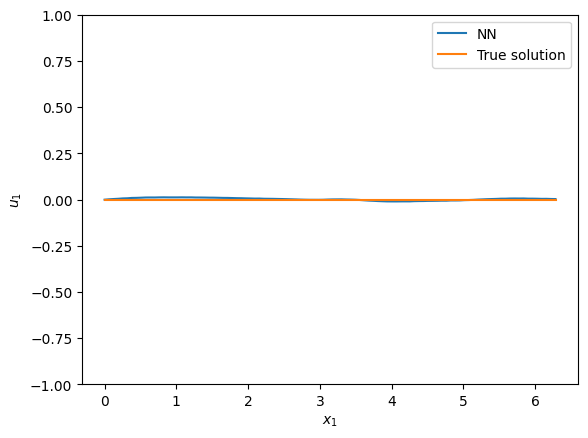

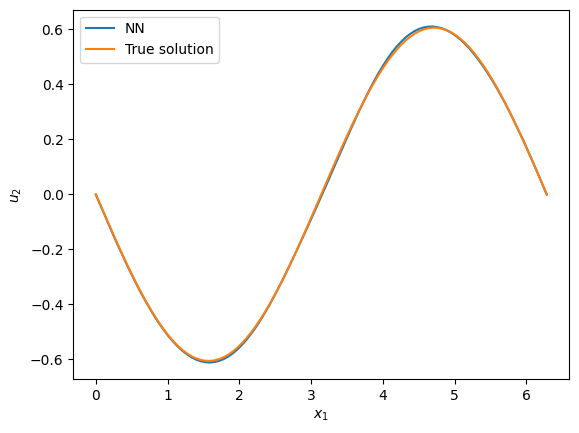

In [6]:
model.error_calculation(
    exact_u_fun=partial(exact_example_u_tensor, nu=nu, T=T),
    exact_p_fun=exact_example_p_tensor,
    nb_pts_spatial=2*126+1
)
model.compare_with_exact(exact_fun=partial(exact_example, nu=nu), exclude_terminal=True, ylim=(-1, 1))

taylor_green_reuse_checkpoint = model.working_dir

[Link to log directory:](logs/20220601-222808-taylor_green_2d-T0.25-nu2)

### T = 1, nu = .2

In [ ]:
T, nu = 1, .2

torch.manual_seed(0)
model = Net(
    problem_name=problem_name,
    f_fun=f_example,
    deriv_map=deriv_map,
    zeta_map=zeta_map,
    deriv_condition_deriv_map=deriv_condition_deriv_map,
    deriv_condition_zeta_map=deriv_condition_zeta_map,
    phi_fun=phi_example,
    device=device,
    x_lo=x_lo,
    x_hi=x_hi,
    T=T,
    verbose=True,
    nu=nu,
    branch_nb_path_per_state=1000,
    branch_nb_states=100000,
    branch_nb_states_per_batch=1000,
    fix_all_dim_except_first=False,
    epochs=10000,
    lr_gamma=0.1,
    branch_lr=1e-2,
    branch_activation="tanh",
    neurons=100,
    layers=2,
    fix_t_dim=False,
    save_for_best_model=False,
    outlier_multiplier=10,
    continue_from_checkpoint=taylor_green_reuse_checkpoint,
)
model.train_and_eval()

The error as in Lejay is calculated as follows.
$\hat{e}_0(t_k)$
& 4.98E-04 & 3.09E-04 & 2.17E-04 & 1.72E-04 & 1.59E-04 & 1.62E-04 & 1.63E-04 & 1.58E-04 & 1.37E-04 & 1.67E-04 & --- \\
$\hat{e}_1(t_k)$
& 2.29E-04 & 2.25E-04 & 2.26E-04 & 2.24E-04 & 2.33E-04 & 2.53E-04 & 2.63E-04 & 2.79E-04 & 2.80E-04 & 2.60E-04 & --- \\
$\hat{e}(t_k)$
& 7.26E-04 & 5.34E-04 & 4.43E-04 & 3.96E-04 & 3.92E-04 & 4.16E-04 & 4.26E-04 & 4.37E-04 & 4.16E-04 & 3.73E-04 & --- \\
\hline

The relative L2 error of u (erru) is calculated as follows.
erru($t_k$)
& 6.89E-03 & 4.83E-03 & 4.60E-03 & 4.77E-03 & 4.91E-03 & 4.96E-03 & 4.95E-03 & 4.91E-03 & 4.89E-03 & 5.28E-03 & --- \\

The relative L2 error of gradient of u (errgu) is calculated as follows.
errgu($t_k$)
& 2.16E-02 & 1.80E-02 & 1.67E-02 & 1.65E-02 & 1.66E-02 & 1.67E-02 & 1.69E-02 & 1.72E-02 & 1.77E-02 & 1.87E-02 & --- \\

The absolute divergence of u (errdivu) is calculated as follows.
errdivu($t_k$)
& 1.52E-02 & 1.05E-02 & 9.91E-03 & 9.62E-03 & 9.39E-03 & 9.5

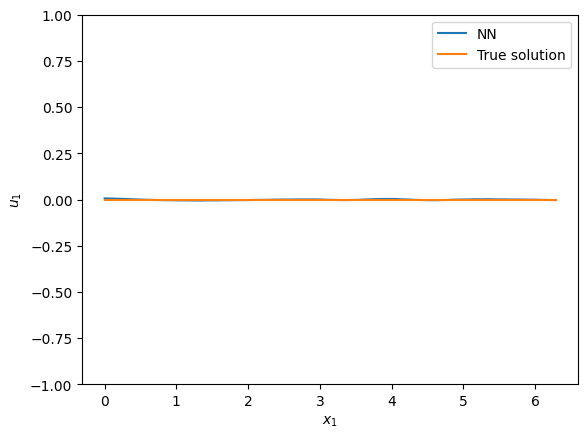

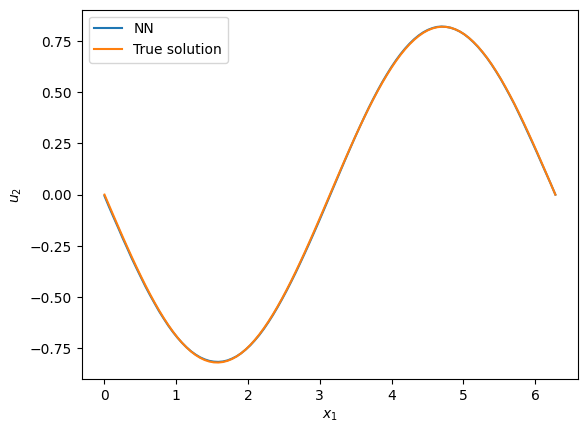

In [8]:
model.error_calculation(
    exact_u_fun=partial(exact_example_u_tensor, nu=nu, T=T),
    exact_p_fun=exact_example_p_tensor,
    nb_pts_spatial=2*126+1
)
model.compare_with_exact(exact_fun=partial(exact_example, nu=nu), exclude_terminal=True, ylim=(-1, 1))

[Link to log directory:](logs/20220601-230945-taylor_green_2d-T1-nu0.2)

### T = 10, nu = .02

In [ ]:
T, nu = 10, .02

torch.manual_seed(0)
model = Net(
    problem_name=problem_name,
    f_fun=f_example,
    deriv_map=deriv_map,
    zeta_map=zeta_map,
    deriv_condition_deriv_map=deriv_condition_deriv_map,
    deriv_condition_zeta_map=deriv_condition_zeta_map,
    phi_fun=phi_example,
    device=device,
    x_lo=x_lo,
    x_hi=x_hi,
    T=T,
    verbose=True,
    nu=nu,
    branch_nb_path_per_state=1000,
    branch_nb_states=100000,
    branch_nb_states_per_batch=1000,
    fix_all_dim_except_first=False,
    epochs=10000,
    lr_gamma=0.1,
    branch_lr=1e-2,
    branch_activation="tanh",
    neurons=100,
    layers=2,
    fix_t_dim=False,
    save_for_best_model=False,
    outlier_multiplier=10,
    continue_from_checkpoint=taylor_green_reuse_checkpoint,
)
model.train_and_eval()

The error as in Lejay is calculated as follows.
$\hat{e}_0(t_k)$
& 4.17E-04 & 4.06E-04 & 4.53E-04 & 3.99E-04 & 2.95E-04 & 2.69E-04 & 3.59E-04 & 4.01E-04 & 2.99E-04 & 2.47E-04 & --- \\
$\hat{e}_1(t_k)$
& 2.08E-04 & 2.50E-04 & 2.55E-04 & 2.14E-04 & 2.08E-04 & 2.25E-04 & 3.01E-04 & 2.85E-04 & 3.39E-04 & 4.43E-04 & --- \\
$\hat{e}(t_k)$
& 4.22E-04 & 4.76E-04 & 5.40E-04 & 4.71E-04 & 3.48E-04 & 3.27E-04 & 4.25E-04 & 4.93E-04 & 4.88E-04 & 5.56E-04 & --- \\
\hline

The relative L2 error of u (erru) is calculated as follows.
erru($t_k$)
& 1.21E-02 & 1.37E-02 & 1.32E-02 & 1.21E-02 & 1.16E-02 & 1.18E-02 & 1.17E-02 & 1.13E-02 & 1.13E-02 & 1.15E-02 & --- \\

The relative L2 error of gradient of u (errgu) is calculated as follows.
errgu($t_k$)
& 2.24E-02 & 1.97E-02 & 1.98E-02 & 2.01E-02 & 2.07E-02 & 2.23E-02 & 2.26E-02 & 2.09E-02 & 2.08E-02 & 2.12E-02 & --- \\

The absolute divergence of u (errdivu) is calculated as follows.
errdivu($t_k$)
& 2.29E-02 & 1.45E-02 & 1.38E-02 & 1.33E-02 & 1.45E-02 & 1.4

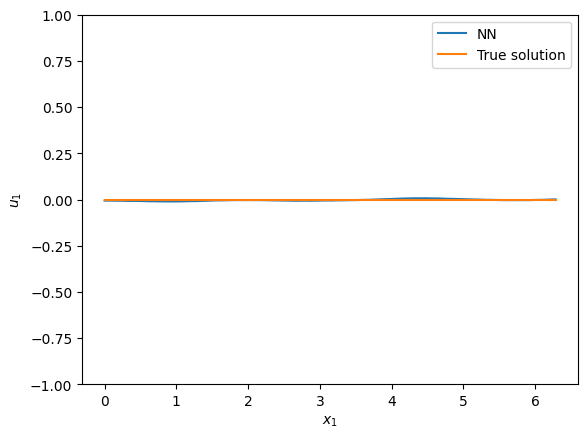

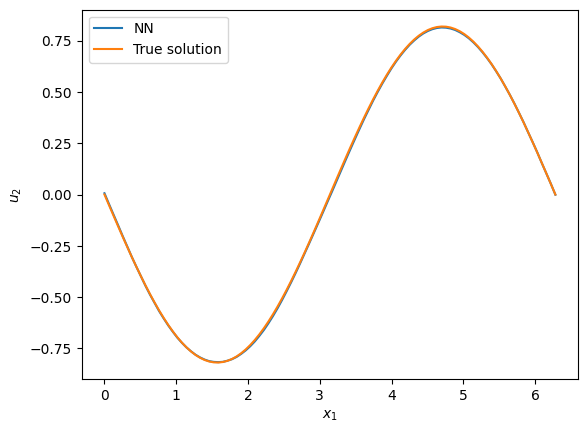

In [10]:
model.error_calculation(
    exact_u_fun=partial(exact_example_u_tensor, nu=nu, T=T),
    exact_p_fun=exact_example_p_tensor,
    nb_pts_spatial=2*126+1
)
model.compare_with_exact(exact_fun=partial(exact_example, nu=nu), exclude_terminal=True, ylim=(-1, 1))

[Link to log directory:](logs/20220601-233151-taylor_green_2d-T10-nu0.02)

## 3-dimensional ABC flow
$$
\begin{cases}
  \displaystyle
  u_1(t, x) = \left(A \sin(x_3) + C \cos(x_2)\right) e^{-\frac{\nu}{2} (T - t)},
  \\
  u_2(t, x) = \left(B \sin(x_1) + A \cos(x_3)\right) e^{-\frac{\nu}{2} (T - t)},
  \\
  u_3(t, x) = \left(C \sin(x_2) + B \cos(x_1)\right) e^{-\frac{\nu}{2} (T - t)},
  \\
  u_0(t, x) = -\left(AC \sin(x_3) \cos(x_2) + BA \sin(x_1) \cos(x_3) + CB \sin(x_2) \cos(x_1)\right) e^{-\nu (T - t)} + c,
\end{cases}
$$
$x=(x_1,x_2,x_3) \in [0,2\pi]^3$.

In [11]:
A = B = C = 0.5

# function definition
deriv_map = np.array(
    [
        [1, 0, 0],  # for nabla p
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 0],  # for u
        [0, 0, 0],
        [0, 0, 0],
        [1, 0, 0],  # for nabla u1
        [0, 1, 0],
        [0, 0, 1],
        [1, 0, 0],  # for nabla u2
        [0, 1, 0],
        [0, 0, 1],
        [1, 0, 0],  # for nabla u3
        [0, 1, 0],
        [0, 0, 1],
    ]
)
zeta_map = np.array([-1, -1, -1, 0, 1, 2, 0, 0, 0, 1, 1, 1, 2, 2, 2])
deriv_condition_deriv_map = np.array(
    [
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1],
    ]
)
deriv_condition_zeta_map = np.array([0, 1, 2])

_, dim = deriv_map.shape

def f_example(y, coordinate):
    """
    idx 0 -> no deriv
    """
    f = -y[coordinate]
    for j in range(dim):
        f += -y[dim + j] * y[2 * dim + dim * coordinate + j]
    return f

def phi_example(x, coordinate):
    if coordinate == 0:
        return A * torch.sin(x[2]) + C * torch.cos(x[1])
    elif coordinate == 1:
        return B * torch.sin(x[0]) + A * torch.cos(x[2])
    else:
        return C * torch.sin(x[1]) + B * torch.cos(x[0])

def exact_example(t, x, T, coordinate, nu):
    if coordinate == 0:
        return (A * np.sin(x[2]) + C * np.cos(x[1])) * np.exp(-nu / 2 * (T - t))
    elif coordinate == 1:
        return (B * np.sin(x[0]) + A * np.cos(x[2])) * np.exp(-nu / 2 * (T - t))
    else:
        return (C * np.sin(x[1]) + B * np.cos(x[0])) * np.exp(-nu / 2 * (T - t))

def exact_example_u_tensor(tx, coordinate, T, nu):
    if coordinate == 0:
        return (A * torch.sin(tx[3]) + C * torch.cos(tx[2])) * torch.exp(-nu / 2 * (T - tx[0]))
    elif coordinate == 1:
        return (B * torch.sin(tx[1]) + A * torch.cos(tx[3])) * torch.exp(-nu / 2 * (T - tx[0]))
    else:
        return (C * torch.sin(tx[2]) + B * torch.cos(tx[1])) * torch.exp(-nu / 2 * (T - tx[0]))

def exact_example_p_tensor(tx):
    return -torch.exp(-nu * (T - tx[0])) * (
        A * C * torch.sin(tx[3]) * torch.cos(tx[2])
        + B * A * torch.sin(tx[1]) * torch.cos(tx[3])
        + C * B * torch.sin(tx[2]) * torch.cos(tx[1])
    )

problem_name = "abc_3d"
t_lo, x_lo, x_hi = 0., 0, 2 * math.pi

### T = .7, nu = .02

In [ ]:
T, nu = .7, .02

torch.manual_seed(0)
model = Net(
    problem_name=problem_name,
    f_fun=f_example,
    deriv_map=deriv_map,
    zeta_map=zeta_map,
    deriv_condition_deriv_map=deriv_condition_deriv_map,
    deriv_condition_zeta_map=deriv_condition_zeta_map,
    phi_fun=phi_example,
    device=device,
    x_lo=x_lo,
    x_hi=x_hi,
    T=T,
    verbose=True,
    nu=nu,
    branch_nb_path_per_state=1000,
    branch_nb_states=100000,
    branch_nb_states_per_batch=1000,
    fix_all_dim_except_first=False,
    epochs=10000,
    lr_gamma=0.1,
    branch_lr=1e-2,
    branch_activation="tanh",
    neurons=100,
    layers=2,
    fix_t_dim=False,
    save_for_best_model=False,
    outlier_multiplier=10,
)
model.train_and_eval()

The error as in Lejay is calculated as follows.
$\hat{e}_0(t_k)$
& 7.45E-04 & 5.52E-04 & 4.65E-04 & 4.13E-04 & 3.66E-04 & 3.34E-04 & 3.12E-04 & 3.26E-04 & 3.70E-04 & 4.41E-04 & --- \\
$\hat{e}_1(t_k)$
& 8.36E-04 & 7.05E-04 & 5.92E-04 & 5.06E-04 & 4.28E-04 & 4.05E-04 & 4.13E-04 & 4.75E-04 & 5.73E-04 & 7.10E-04 & --- \\
$\hat{e}_2(t_k)$
& 8.56E-04 & 6.93E-04 & 5.51E-04 & 4.33E-04 & 4.20E-04 & 4.69E-04 & 4.99E-04 & 5.23E-04 & 5.36E-04 & 5.27E-04 & --- \\
$\hat{e}(t_k)$
& 1.21E-03 & 9.20E-04 & 7.94E-04 & 7.60E-04 & 7.18E-04 & 7.09E-04 & 6.95E-04 & 7.14E-04 & 7.39E-04 & 8.00E-04 & --- \\
\hline

The relative L2 error of u (erru) is calculated as follows.
erru($t_k$)
& 1.36E-02 & 1.20E-02 & 1.11E-02 & 1.07E-02 & 1.04E-02 & 1.03E-02 & 1.03E-02 & 1.03E-02 & 1.06E-02 & 1.13E-02 & --- \\

The relative L2 error of gradient of u (errgu) is calculated as follows.
errgu($t_k$)
& 4.49E-02 & 4.30E-02 & 4.16E-02 & 4.07E-02 & 4.01E-02 & 3.97E-02 & 3.96E-02 & 3.97E-02 & 4.01E-02 & 4.10E-02 & --- \\

The 

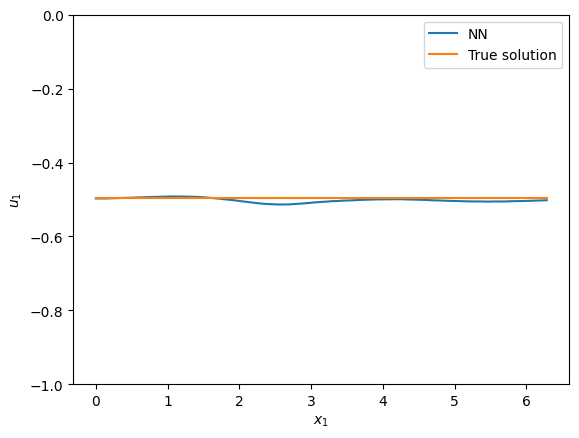

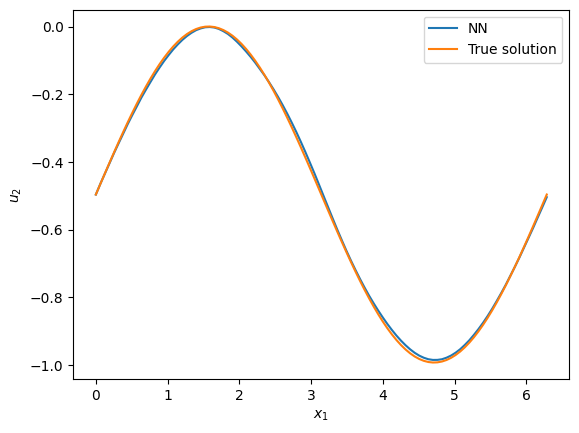

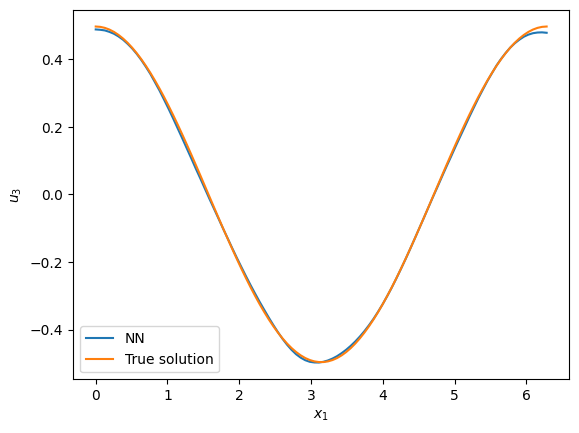

In [14]:
model.error_calculation(
    exact_u_fun=partial(exact_example_u_tensor, nu=nu, T=T),
    exact_p_fun=exact_example_p_tensor,
    nb_pts_spatial=2*45+1
)
model.compare_with_exact(exact_fun=partial(exact_example, nu=nu), exclude_terminal=True, ylim=(-1, 0))

abc_reuse_checkpoint = model.working_dir

[Link to log directory:](logs/20220601-235327-abc_3d-T0.7-nu0.02)

### T = .7, nu = .0002

In [ ]:
T, nu = .7, .0002

torch.manual_seed(0)
model = Net(
    problem_name=problem_name,
    f_fun=f_example,
    deriv_map=deriv_map,
    zeta_map=zeta_map,
    deriv_condition_deriv_map=deriv_condition_deriv_map,
    deriv_condition_zeta_map=deriv_condition_zeta_map,
    phi_fun=phi_example,
    device=device,
    x_lo=x_lo,
    x_hi=x_hi,
    T=T,
    verbose=True,
    nu=nu,
    branch_nb_path_per_state=1000,
    branch_nb_states=100000,
    branch_nb_states_per_batch=1000,
    fix_all_dim_except_first=False,
    epochs=10000,
    lr_gamma=0.1,
    branch_lr=1e-2,
    branch_activation="tanh",
    neurons=100,
    layers=2,
    fix_t_dim=False,
    save_for_best_model=False,
    outlier_multiplier=10,
    continue_from_checkpoint=abc_reuse_checkpoint,
)
model.train_and_eval()

The error as in Lejay is calculated as follows.
$\hat{e}_0(t_k)$
& 1.27E-04 & 1.26E-04 & 1.23E-04 & 1.21E-04 & 1.15E-04 & 1.09E-04 & 9.84E-05 & 8.90E-05 & 8.98E-05 & 1.10E-04 & --- \\
$\hat{e}_1(t_k)$
& 2.51E-04 & 1.98E-04 & 1.63E-04 & 1.35E-04 & 1.15E-04 & 1.04E-04 & 1.01E-04 & 1.02E-04 & 1.08E-04 & 1.31E-04 & --- \\
$\hat{e}_2(t_k)$
& 1.20E-04 & 9.82E-05 & 8.83E-05 & 9.26E-05 & 9.53E-05 & 9.18E-05 & 8.79E-05 & 8.19E-05 & 9.20E-05 & 1.09E-04 & --- \\
$\hat{e}(t_k)$
& 2.98E-04 & 2.23E-04 & 1.68E-04 & 1.38E-04 & 1.35E-04 & 1.41E-04 & 1.43E-04 & 1.52E-04 & 1.61E-04 & 1.74E-04 & --- \\
\hline

The relative L2 error of u (erru) is calculated as follows.
erru($t_k$)
& 5.91E-03 & 5.33E-03 & 5.03E-03 & 4.91E-03 & 4.89E-03 & 4.92E-03 & 4.97E-03 & 5.05E-03 & 5.21E-03 & 5.51E-03 & --- \\

The relative L2 error of gradient of u (errgu) is calculated as follows.
errgu($t_k$)
& 2.12E-02 & 2.08E-02 & 2.06E-02 & 2.05E-02 & 2.04E-02 & 2.05E-02 & 2.05E-02 & 2.07E-02 & 2.09E-02 & 2.11E-02 & --- \\

The 

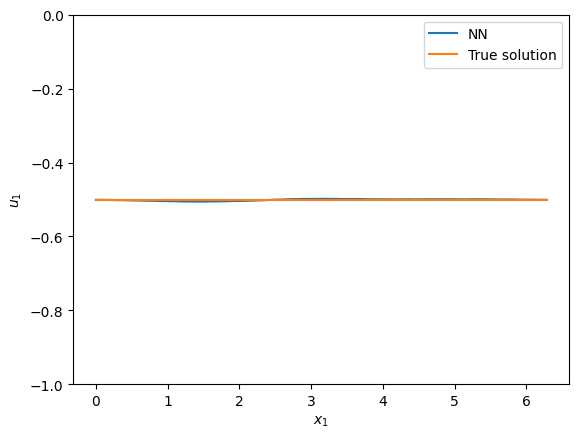

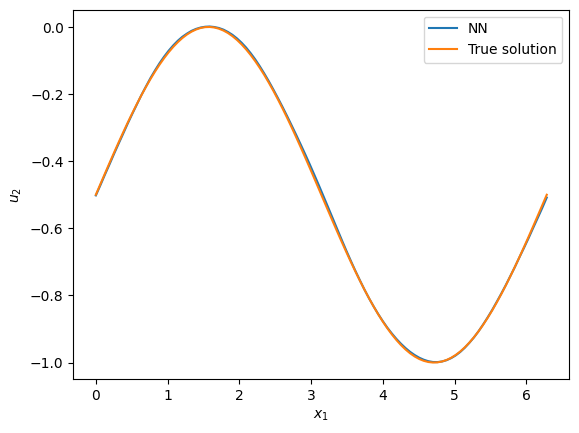

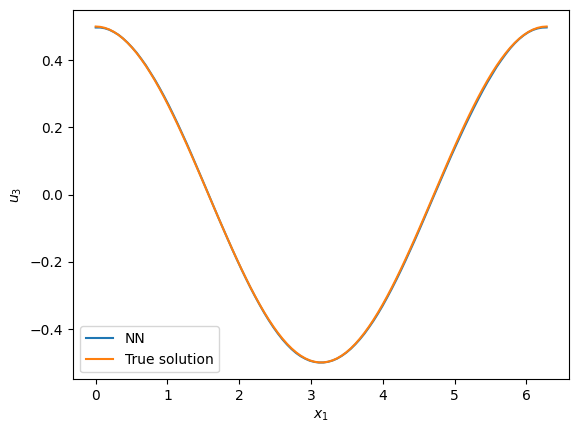

In [16]:
model.error_calculation(
    exact_u_fun=partial(exact_example_u_tensor, nu=nu, T=T),
    exact_p_fun=exact_example_p_tensor,
    nb_pts_spatial=2*45+1
)
model.compare_with_exact(exact_fun=partial(exact_example, nu=nu), exclude_terminal=True, ylim=(-1, 0))

[Link to log directory:](logs/20220602-013139-abc_3d-T0.7-nu0.0002)

## 2-dimensional symmetric rotating flow
We use the terminal condition of
$$
\begin{cases}
\phi_0(x) &= \frac{f'(x_1)}{f(x_1)} \exp\left( -\frac{g(x_0)}{f(x_1)} \right),
\\
\phi_1(x) &= \frac{g'(x_0)}{g(x_0)} \exp\left( -\frac{g(x_0)}{f(x_1)} \right),
\end{cases}
$$
where
$x=(x_1,x_2) \in [-2,2]^2$,
$f(x) = \frac{1}{1+x^2}$,
and
$g(x) = 1 + x^2$.
It can be checked that the terminal condition satisfies the divergence free condition.

In [11]:
problem_name = "navier_stokes_rotating_flow"

def f(x):
    return 1 / (1 + x**2)

def fprime(x):
    return -2 * x / (1 + x**2)**2

def g(x):
    return 1 + x**2

def gprime(x):
    return 2 * x

t_lo, x_lo, x_hi = 0., -2, 2

# function definition
deriv_map = np.array(
    [
        [1, 0],  # for nabla p
        [0, 1],
        [0, 0],  # for u
        [0, 0],
        [1, 0],  # for nabla u1
        [0, 1],
        [1, 0],  # for nabla u2
        [0, 1],
    ]
)
zeta_map = np.array([-1, -1, 0, 1, 0, 0, 1, 1])
deriv_condition_deriv_map = np.array(
    [
        [1, 0],
        [0, 1],
    ]
)
deriv_condition_zeta_map = np.array([0, 1])
_, dim = deriv_map.shape

def f_example(y, coordinate):
    """
    idx 0 -> no deriv
    """
    f = -y[coordinate]
    for j in range(dim):
        f += -y[dim + j] * y[2 * dim + dim * coordinate + j]
    return f

def phi_example(x, coordinate):
    if coordinate == 0:
        return fprime(x[1]) / f(x[1]) * torch.exp(-g(x[0]) / f(x[1]))
    else:
        return gprime(x[0]) / g(x[0]) * torch.exp(-g(x[0]) / f(x[1]))

def plot_wall(model, nb_spatial, x_lo, x_hi):
    lw, delta = 5, 1e-1
    plt.axis('scaled')
    plt.xlim(x_lo, x_hi)
    plt.ylim(x_lo, x_hi)

def plot_quiver_and_color(model, tt, x_lo, x_hi, x1, x2, u, nb_spatial, vmin=None, vmax=None, plt_velocity=True):
    # for velocity, the magnitute is the length
    # for pressure, the magnitute is simply itself
    magnitute = torch.sqrt(u[0]**2 + u[1]**2) if plt_velocity else u[0]
    subject = "velocity" if plt_velocity else "pressure"
    f = plt.figure()
    s = f.add_subplot(1, 1, 1, xlabel='$x$', ylabel='$y$')
    cmap=cm.coolwarm
    im = s.imshow(
        magnitute.reshape(nb_spatial, nb_spatial),
        cmap=cmap,
        extent=(x_lo, x_hi, x_lo, x_hi),
        origin='lower',
        vmin=vmin,
        vmax=vmax,
    )
    f.colorbar(im)
    plot_wall(model, nb_spatial, x_lo, x_hi)
    
    if plt_velocity:
        # use coarser grid
        x1 = x1.reshape(nb_spatial, nb_spatial)[::5, ::5].reshape(-1)
        x2 = x2.reshape(nb_spatial, nb_spatial)[::5, ::5].reshape(-1)
        u = u.reshape(2, nb_spatial, nb_spatial)[:, ::5, ::5].reshape(2, -1)
        plt.quiver(x1, x2, u[0], u[1], scale=10*(vmax - vmin))
        plt.title(f"{subject} flow at t = {tt}")
    plt.title(f"{subject} flow at t = {tt}")
    f.savefig(f"{model.working_dir}/plot/t{tt}_{subject}.png", bbox_inches="tight", dpi=300)
    if isinstance(tt, numbers.Number) and (math.isclose(tt, model.t_lo) or math.isclose(tt, model.T)):
        plt.show()
    plt.close()

def plot_fluid(model, nb_time=21, nb_spatial=101, x_lo=None, x_hi=None):
    x_lo = model.x_lo if x_lo is None else x_lo
    x_hi = model.x_hi if x_hi is None else x_hi
    x1, x2 = np.meshgrid(
        np.linspace(x_lo, x_hi, nb_spatial + 2)[1:-1],
        np.linspace(x_lo, x_hi, nb_spatial + 2)[1:-1]
    )
    x1, x2 = x1.reshape(-1), x2.reshape(-1)
    time_arr = np.linspace(model.t_lo, model.T, nb_time)
    u = []
    for tt in time_arr:
        # create x
        x_tensor = torch.tensor(
            np.stack((tt * np.ones_like(x1), x1, x2)),
            device=model.device,
            dtype=torch.get_default_dtype()
        ).reshape(3, -1)
    
        # calculate u
        u.append(model(x_tensor.T, patch=0).T.detach().cpu())
    # merge all u together
    u = torch.stack(u, dim=0)
    
    # calculate terminal u & p
    terminal_u = torch.stack((
        model.phi_fun(x_tensor[1:], 0).cpu(),
        model.phi_fun(x_tensor[1:], 1).cpu(),
    ))
    p = model(x_tensor[1:].T, patch=0, p_or_u="p").T.detach().cpu()
    
    # plot
    magnitute = torch.sqrt(u[:, 0, :]**2 + u[:, 1, :]**2)
    magnitute = magnitute[~magnitute.isnan()]  # filter nan
    vmin, vmax = magnitute.min().item(), magnitute.max().item()
    for idx, tt in enumerate(time_arr):
        plot_quiver_and_color(model, tt, x_lo, x_hi, x1, x2, u[idx], nb_spatial, vmin, vmax)
    plot_quiver_and_color(model, "terminal", x_lo, x_hi, x1, x2, terminal_u, nb_spatial, vmin, vmax)
    plot_quiver_and_color(model, model.T, x_lo, x_hi, x1, x2, p, nb_spatial, plt_velocity=False)
    
    return x1, x2, u, p

Logs are saved in /home/nguwijy/repo/deep_branching_with_domain/logs/20220609-201837-navier_stokes_rotating_flow-T100-nu0.02
Patch 0: generation of p samples take 1505.5076336860657 seconds.
Patch  0: epoch    0 with loss 1.81E+00
Patch  0: epoch  500 with loss 4.17E-03
Patch  0: epoch 1000 with loss 3.93E-03
Patch  0: epoch 1500 with loss 3.40E-03
Patch  0: epoch 2000 with loss 2.36E-03
Patch  0: epoch 2500 with loss 1.29E-03
Patch  0: epoch 3000 with loss 5.61E-04
Patch  0: epoch 3500 with loss 2.06E-04
Patch  0: epoch 4000 with loss 9.83E-05
Patch  0: epoch 4500 with loss 1.17E-04
Patch  0: epoch 5000 with loss 4.31E-05
Patch  0: epoch 5500 with loss 3.22E-05
Patch  0: epoch 6000 with loss 2.54E-05
Patch  0: epoch 6500 with loss 1.15E-04
Patch  0: epoch 7000 with loss 2.47E-05
Patch  0: epoch 7500 with loss 1.33E-05
Patch  0: epoch 8000 with loss 1.11E-05
Patch  0: epoch 8500 with loss 2.66E-05
Patch  0: epoch 9000 with loss 7.84E-06
Patch  0: epoch 9500 with loss 8.09E-06
Patch  0:

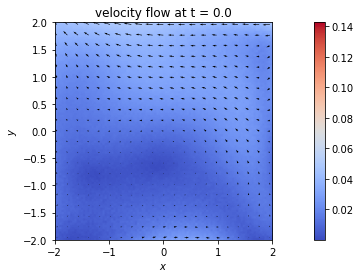

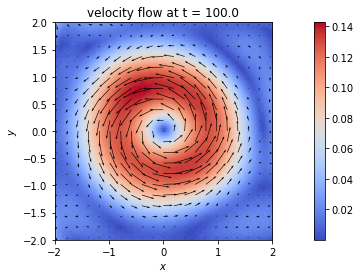

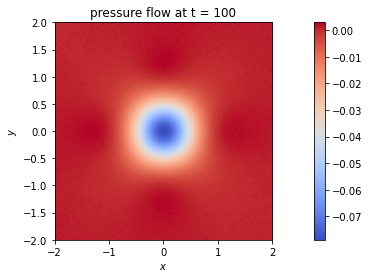

In [5]:
# use the trained model below
nu = .02
patches = 1
T = patches * 100

# define NN and train
torch.manual_seed(0)
model = Net(
    problem_name=problem_name,
    f_fun=f_example,
    deriv_map=deriv_map,
    zeta_map=zeta_map,
    deriv_condition_deriv_map=deriv_condition_deriv_map,
    deriv_condition_zeta_map=deriv_condition_zeta_map,
    phi_fun=phi_example,
    device=device,
    x_lo=x_lo,
    x_hi=x_hi,
    T=T,
    verbose=True,
    nu=nu,
    branch_patches=patches,
    branch_nb_path_per_state=1000,
    branch_nb_states=100000,  # change to 100000
    branch_nb_states_per_batch=1000,
    epochs=10000,  # change to 10000
    fix_all_dim_except_first=False,
    fix_t_dim=False,  # change to False
    overtrain_rate=0.,
    outlier_multiplier=10,
    save_as_tmp=False,  # change to False
)
model.train_and_eval(debug_mode=False)
x1, x2, u, p = plot_fluid(model, nb_time=21) # change to 21

[Link to log directory:](logs/20220609-201837-navier_stokes_rotating_flow-T100-nu0.02)

Finally, we show the gif of simulated flow.
![velocity](logs/20220609-201837-navier_stokes_rotating_flow-T100-nu0.02/plot/velocity.gif "velocity")

## 2-dimensional asymmetric rotating flow
We use the terminal condition of
$$
\begin{cases}
\phi_0(x) &= \frac{f'(x_1)}{f(x_1)} \exp\left( -\frac{g(x_0)}{f(x_1)} \right),
\\
\phi_1(x) &= \frac{g'(x_0)}{g(x_0)} \exp\left( -\frac{g(x_0)}{f(x_1)} \right),
\end{cases}
$$
where
$x=(x_1,x_2) \in [-3,3]^2$,
$f(x) = \frac{2 + \sin(x)}{1+x^2}$,
and
$g(x) = \frac{e^{x^2}}{2 + x^3 + x^4}$.
It can be checked that the terminal condition satisfies the divergence free condition.

In [4]:
problem_name = "navier_stokes_rotating_flow"

def f(x):
    return (2 + torch.sin(x)) / (1 + x**2)

def fprime(x):
    return (
        ((1 + x**2) * torch.cos(x) - 2 * x * (2  + torch.sin(x)))
        / (1 + x**2)**2
    )

def g(x):
    return torch.exp(x**2) / (2 + x**3 + x**4)

def gprime(x):
    return (
        torch.exp(x**2) * x
        * (2 * x**4 + 2 * x**3 - 4 * x**2 - 3 * x + 4)
        / (2 + x**3 + x**4)**2
    )

t_lo, x_lo, x_hi = 0., -3, 3

# function definition
deriv_map = np.array(
    [
        [1, 0],  # for nabla p
        [0, 1],
        [0, 0],  # for u
        [0, 0],
        [1, 0],  # for nabla u1
        [0, 1],
        [1, 0],  # for nabla u2
        [0, 1],
    ]
)
zeta_map = np.array([-1, -1, 0, 1, 0, 0, 1, 1])
deriv_condition_deriv_map = np.array(
    [
        [1, 0],
        [0, 1],
    ]
)
deriv_condition_zeta_map = np.array([0, 1])
_, dim = deriv_map.shape

def f_example(y, coordinate):
    """
    idx 0 -> no deriv
    """
    f = -y[coordinate]
    for j in range(dim):
        f += -y[dim + j] * y[2 * dim + dim * coordinate + j]
    return f

def phi_example(x, coordinate):
    if coordinate == 0:
        return fprime(x[1]) / f(x[1]) * torch.exp(-g(x[0]) / f(x[1]))
    else:
        return gprime(x[0]) / g(x[0]) * torch.exp(-g(x[0]) / f(x[1]))

def plot_wall(model, nb_spatial, x_lo, x_hi):
    lw, delta = 5, 1e-1
    plt.axis('scaled')
    plt.xlim(x_lo, x_hi)
    plt.ylim(x_lo, x_hi)

def plot_quiver_and_color(model, tt, x_lo, x_hi, x1, x2, u, nb_spatial, vmin=None, vmax=None, plt_velocity=True):
    # for velocity, the magnitute is the length
    # for pressure, the magnitute is simply itself
    magnitute = torch.sqrt(u[0]**2 + u[1]**2) if plt_velocity else u[0]
    subject = "velocity" if plt_velocity else "pressure"
    f = plt.figure()
    s = f.add_subplot(1, 1, 1, xlabel='$x$', ylabel='$y$')
    cmap=cm.coolwarm
    im = s.imshow(
        magnitute.reshape(nb_spatial, nb_spatial),
        cmap=cmap,
        extent=(x_lo, x_hi, x_lo, x_hi),
        origin='lower',
        vmin=vmin,
        vmax=vmax,
    )
    f.colorbar(im)
    plot_wall(model, nb_spatial, x_lo, x_hi)
    
    if plt_velocity:
        # use coarser grid
        x1 = x1.reshape(nb_spatial, nb_spatial)[::5, ::5].reshape(-1)
        x2 = x2.reshape(nb_spatial, nb_spatial)[::5, ::5].reshape(-1)
        u = u.reshape(2, nb_spatial, nb_spatial)[:, ::5, ::5].reshape(2, -1)
        plt.quiver(x1, x2, u[0], u[1], scale=10*(vmax - vmin))
        plt.title(f"{subject} flow at t = {tt}")
    plt.title(f"{subject} flow at t = {tt}")
    f.savefig(f"{model.working_dir}/plot/t{tt}_{subject}.png", bbox_inches="tight", dpi=300)
    if isinstance(tt, numbers.Number) and (math.isclose(tt, model.t_lo) or math.isclose(tt, model.T)):
        plt.show()
    plt.close()

def plot_fluid(model, nb_time=21, nb_spatial=101, x_lo=None, x_hi=None):
    x_lo = model.x_lo if x_lo is None else x_lo
    x_hi = model.x_hi if x_hi is None else x_hi
    x1, x2 = np.meshgrid(
        np.linspace(x_lo, x_hi, nb_spatial + 2)[1:-1],
        np.linspace(x_lo, x_hi, nb_spatial + 2)[1:-1]
    )
    x1, x2 = x1.reshape(-1), x2.reshape(-1)
    time_arr = np.linspace(model.t_lo, model.T, nb_time)
    u = []
    for tt in time_arr:
        # create x
        x_tensor = torch.tensor(
            np.stack((tt * np.ones_like(x1), x1, x2)),
            device=model.device,
            dtype=torch.get_default_dtype()
        ).reshape(3, -1)
    
        # calculate u
        u.append(model(x_tensor.T, patch=0).T.detach().cpu())
    # merge all u together
    u = torch.stack(u, dim=0)
    
    # calculate terminal u & p
    terminal_u = torch.stack((
        model.phi_fun(x_tensor[1:], 0).cpu(),
        model.phi_fun(x_tensor[1:], 1).cpu(),
    ))
    p = model(x_tensor[1:].T, patch=0, p_or_u="p").T.detach().cpu()
    
    # plot
    magnitute = torch.sqrt(u[:, 0, :]**2 + u[:, 1, :]**2)
    magnitute = magnitute[~magnitute.isnan()]  # filter nan
    vmin, vmax = magnitute.min().item(), magnitute.max().item()
    for idx, tt in enumerate(time_arr):
        plot_quiver_and_color(model, tt, x_lo, x_hi, x1, x2, u[idx], nb_spatial, vmin, vmax)
    plot_quiver_and_color(model, "terminal", x_lo, x_hi, x1, x2, terminal_u, nb_spatial, vmin, vmax)
    plot_quiver_and_color(model, model.T, x_lo, x_hi, x1, x2, p, nb_spatial, plt_velocity=False)
    
    return x1, x2, u, p

In [ ]:
# use the trained p above
nu = .02
patches = 1
T = patches * 40

# define NN and train
torch.manual_seed(0)
model = Net(
    problem_name=problem_name,
    f_fun=f_example,
    deriv_map=deriv_map,
    zeta_map=zeta_map,
    deriv_condition_deriv_map=deriv_condition_deriv_map,
    deriv_condition_zeta_map=deriv_condition_zeta_map,
    phi_fun=phi_example,
    device=device,
    x_lo=x_lo,
    x_hi=x_hi,
    T=T,
    verbose=True,
    nu=nu,
    branch_patches=patches,
    branch_nb_path_per_state=1000,
    branch_nb_states=100000,  # change to 100000
    branch_nb_states_per_batch=1000,
    epochs=10000,  # change to 10000
    fix_all_dim_except_first=False,
    fix_t_dim=False,  # change to False
    overtrain_rate=0.,
    outlier_multiplier=10,
    save_as_tmp=False,  # change to False
    div_condition_coeff=0.,
)
model.train_and_eval(debug_mode=False)

[Link to log directory:](logs/20220616-232041-navier_stokes_rotating_flow-T40-nu0.02)

The high velocity at t = 0 makes the scaling unfit for studying the velocity at other times.
Using the same trained model, we next produce the plot of $t \in [5, 40]$.

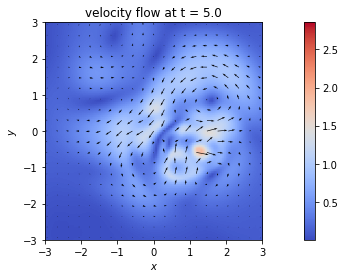

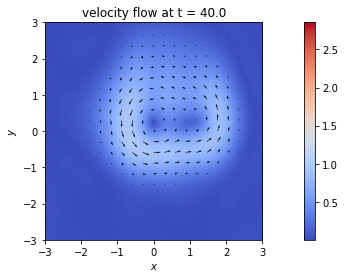

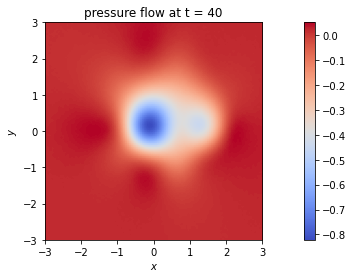

In [8]:
model.t_lo = 5
x1, x2, u, p = plot_fluid(model, nb_time=36)
model.t_lo = 0
!mkdir -p {model.working_dir + '/plot/5_to_40/'}
!mv {model.working_dir + '/plot/*png'} {model.working_dir + '/plot/5_to_40/'}

Finally, we show the gif of simulated flow.
![velocity](logs/20220616-232041-navier_stokes_rotating_flow-T40-nu0.02/plot/5_to_40/velocity.gif "velocity")

## Comparison with DGM method

In this section,  we compare deep branching method with the DGM method in the case of 2D Taylor-Green vortex. Recall that in the simulation above, we have seen that deep branching method works well in the 2D Taylor-Green vortex in the domain of $[0, 2\pi]^2$ without imposing boundary condition.

For this, we try four possibilities for DGM:
1. without boundary condition $[0, 2\pi]^2$ (not working well)
2. with boundary condition $[0, 2\pi]^2$ (not working well)
3. without boundary condition $[0, 1]^2$ (not working well)
4. with boundary condition $[0, 1]^2$ (works well)

Our experiment concludes that in the case of 2D Taylor-Green vortex, DGM method requires boundary condition in small domain to work well.

In [ ]:
from branch.galerkin import DGMNet

In [4]:
T, nu = .25, 2

# function definition
deriv_map = np.array(
    [
        [1, 0],  # for nabla p
        [0, 1],
        [0, 0],  # for u
        [0, 0],
        [1, 0],  # for nabla u1
        [0, 1],
        [1, 0],  # for nabla u2
        [0, 1],
        [2, 0],  # for Laplacian
        [0, 2],
        [2, 0],
        [0, 2],
    ]
)
zeta_map = np.array([-1, -1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1])
deriv_condition_deriv_map = np.array(
    [
        [1, 0],
        [0, 1],
    ]
)
deriv_condition_zeta_map = np.array([0, 1])
_, dim = deriv_map.shape

def f_example(y, coordinate):
    """
    idx 0 -> no deriv
    """
    f = -y[coordinate]
    for j in range(dim):
        f += -y[dim + j] * y[2 * dim + dim * coordinate + j]
        # Laplacian
        f += nu / 2 * (y[2 * dim + dim * dim + dim * coordinate + j])
    return f

def phi_example(x, coordinate):
    if coordinate == 0:
        return -torch.cos(x[0]) * torch.sin(x[1])
    else:
        return torch.sin(x[0]) * torch.cos(x[1])

def exact_example(t, x, T, coordinate, nu):
    if coordinate == 0:
        return -np.cos(x[0]) * np.sin(x[1]) * np.exp(-nu * (T - t))
    else:
        return np.sin(x[0]) * np.cos(x[1]) * np.exp(-nu * (T - t))

def exact_example_u_tensor(tx, coordinate, T, nu):
    if coordinate == 0:
        return -torch.cos(tx[1]) * torch.sin(tx[2]) * torch.exp(-nu * (T - tx[0]))
    else:
        return torch.sin(tx[1]) * torch.cos(tx[2]) * torch.exp(-nu * (T - tx[0]))

def exact_example_p_tensor(tx):
    return (
        -1/ 4
        * torch.exp(-2 * nu * (T - tx[0]))
        * (torch.cos(2 * tx[1]) + torch.cos(2 * tx[2]))
    )

def boundary_fun(tx, coordinate):
    if coordinate == 0:
        return -torch.cos(tx[1]) * torch.sin(tx[2]) * torch.exp(-nu * (T - tx[0]))
    else:
        return torch.sin(tx[1]) * torch.cos(tx[2]) * torch.exp(-nu * (T - tx[0]))

problem_name = "taylor_green_2d"
t_lo, x_lo, x_hi = 0., 0, 2 * math.pi

### without boundary condition $[0, 2 \pi]^2$

In [5]:
torch.manual_seed(0)
model = DGMNet(
    problem_name=problem_name,
    dgm_f_fun=f_example,
    phi_fun=phi_example,
    dgm_deriv_map=deriv_map,
    dgm_zeta_map=zeta_map,
    deriv_condition_deriv_map=deriv_condition_deriv_map,
    deriv_condition_zeta_map=deriv_condition_zeta_map,
    t_hi=T,
    x_lo=x_lo,
    x_hi=x_hi,
    device=device,
    verbose=True,
    epochs=20000,
    dgm_nb_states=10000,
)
model.train_and_eval()

Logs are saved in /home/oem/deep_branching_with_domain/notebooks/logs/20221201-214406-taylor_green_2d
Epoch 0 with loss 0.3043270409107208
Epoch 500 with loss 0.040867533534765244
Epoch 1000 with loss 0.019656455144286156
Epoch 1500 with loss 0.012412120588123798
Epoch 2000 with loss 0.008362386375665665
Epoch 2500 with loss 0.005044164601713419
Epoch 3000 with loss 0.002795727225020528
Epoch 3500 with loss 0.0019165088888257742
Epoch 4000 with loss 0.0015609327238053083
Epoch 4500 with loss 0.0014259821036830544
Epoch 5000 with loss 0.0008224225603044033
Epoch 5500 with loss 0.0006808182806707919
Epoch 6000 with loss 0.0025400526355952024
Epoch 6500 with loss 0.0007891588611528277
Epoch 7000 with loss 0.0009599835029803216
Epoch 7500 with loss 0.0007467587129212916
Epoch 8000 with loss 0.0010915236780419946
Epoch 8500 with loss 0.00034548903931863606
Epoch 9000 with loss 0.0006153204594738781
Epoch 9500 with loss 0.000384280807338655
Epoch 10000 with loss 0.0004880135238636285
Epoch 1

The error as in Lejay is calculated as follows.
$\hat{e}_0(t_k)$
& 8.00E-01 & 7.79E-01 & 7.57E-01 & 7.36E-01 & 7.15E-01 & 6.94E-01 & 6.73E-01 & 6.52E-01 & 6.31E-01 & 6.11E-01 & --- \\
$\hat{e}_1(t_k)$
& 4.55E-01 & 3.81E-01 & 3.11E-01 & 2.46E-01 & 1.87E-01 & 1.35E-01 & 8.92E-02 & 5.19E-02 & 2.39E-02 & 6.16E-03 & --- \\
$\hat{e}(t_k)$
& 8.67E-01 & 8.33E-01 & 8.00E-01 & 7.68E-01 & 7.38E-01 & 7.09E-01 & 6.82E-01 & 6.56E-01 & 6.33E-01 & 6.11E-01 & --- \\
\hline

The relative L2 error of u (erru) is calculated as follows.
erru($t_k$)
& 1.01E+00 & 9.20E-01 & 8.35E-01 & 7.57E-01 & 6.88E-01 & 6.26E-01 & 5.73E-01 & 5.29E-01 & 4.94E-01 & 4.67E-01 & --- \\

The relative L2 error of gradient of u (errgu) is calculated as follows.
errgu($t_k$)
& 7.15E-01 & 6.48E-01 & 5.85E-01 & 5.27E-01 & 4.73E-01 & 4.24E-01 & 3.79E-01 & 3.41E-01 & 3.09E-01 & 2.85E-01 & --- \\

The absolute divergence of u (errdivu) is calculated as follows.
errdivu($t_k$)
& 2.21E-02 & 1.95E-02 & 1.88E-02 & 2.01E-02 & 2.29E-02 & 2.6

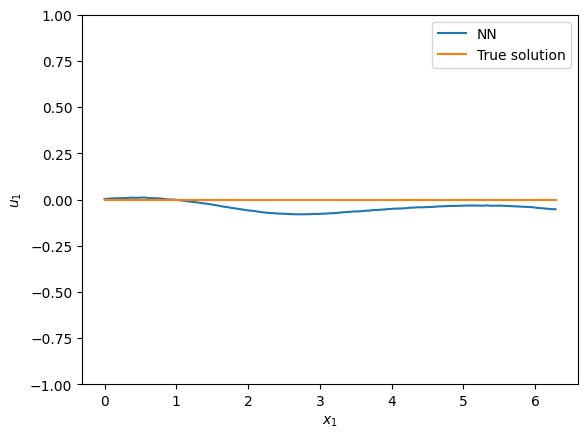

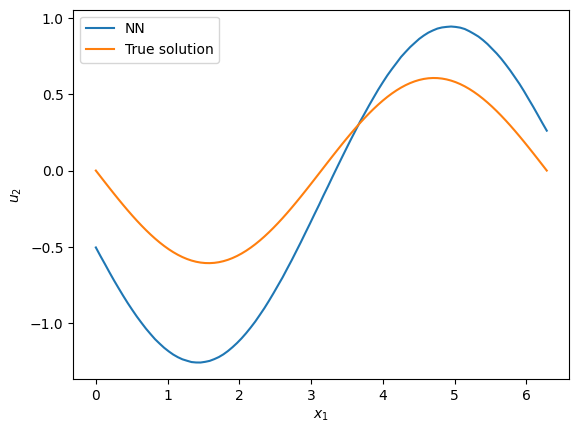

In [6]:
model.error_calculation(
    exact_u_fun=partial(exact_example_u_tensor, nu=nu, T=T),
    exact_p_fun=exact_example_p_tensor,
    nb_pts_spatial=2*126+1
)
model.compare_with_exact(exact_fun=partial(exact_example, nu=nu), exclude_terminal=True, ylim=(-1, 1))

### with boundary condition $[0, 2 \pi]^2$

In [7]:
torch.manual_seed(0)
model = DGMNet(
    problem_name=problem_name,
    dgm_f_fun=f_example,
    phi_fun=phi_example,
    dgm_deriv_map=deriv_map,
    dgm_zeta_map=zeta_map,
    deriv_condition_deriv_map=deriv_condition_deriv_map,
    deriv_condition_zeta_map=deriv_condition_zeta_map,
    t_hi=T,
    x_lo=x_lo,
    x_hi=x_hi,
    device=device,
    verbose=True,
    epochs=20000,
    dgm_nb_states=10000,
    boundary_fun=boundary_fun,
    overtrain_rate=.0,
)
model.train_and_eval()

Logs are saved in /home/oem/deep_branching_with_domain/notebooks/logs/20221201-222300-taylor_green_2d
Epoch 0 with loss 0.4430675506591797
Epoch 500 with loss 0.04437808692455292
Epoch 1000 with loss 0.02208627387881279
Epoch 1500 with loss 0.013971281237900257
Epoch 2000 with loss 0.01128695160150528
Epoch 2500 with loss 0.009253391996026039
Epoch 3000 with loss 0.005532004404813051
Epoch 3500 with loss 0.004072746727615595
Epoch 4000 with loss 0.0036441884003579617
Epoch 4500 with loss 0.003620501607656479
Epoch 5000 with loss 0.0021610127296298742
Epoch 5500 with loss 0.0033326561097055674
Epoch 6000 with loss 0.0015168554382398725
Epoch 6500 with loss 0.0014507090672850609
Epoch 7000 with loss 0.0018507157219573855
Epoch 7500 with loss 0.0010994051117449999
Epoch 8000 with loss 0.0010362261673435569
Epoch 8500 with loss 0.0007545578991994262
Epoch 9000 with loss 0.0007529332069680095
Epoch 9500 with loss 0.0008737088646739721
Epoch 10000 with loss 0.0010409317910671234
Epoch 10500 

The error as in Lejay is calculated as follows.
$\hat{e}_0(t_k)$
& 2.21E+00 & 2.11E+00 & 2.01E+00 & 1.91E+00 & 1.81E+00 & 1.72E+00 & 1.62E+00 & 1.52E+00 & 1.43E+00 & 1.34E+00 & --- \\
$\hat{e}_1(t_k)$
& 1.40E-01 & 1.21E-01 & 1.01E-01 & 8.25E-02 & 6.42E-02 & 4.70E-02 & 3.16E-02 & 1.85E-02 & 8.29E-03 & 1.90E-03 & --- \\
$\hat{e}(t_k)$
& 2.21E+00 & 2.11E+00 & 2.01E+00 & 1.91E+00 & 1.81E+00 & 1.72E+00 & 1.62E+00 & 1.52E+00 & 1.43E+00 & 1.34E+00 & --- \\
\hline

The relative L2 error of u (erru) is calculated as follows.
erru($t_k$)
& 1.03E+00 & 9.49E-01 & 8.74E-01 & 8.05E-01 & 7.42E-01 & 6.84E-01 & 6.33E-01 & 5.87E-01 & 5.47E-01 & 5.12E-01 & --- \\

The relative L2 error of gradient of u (errgu) is calculated as follows.
errgu($t_k$)
& 8.07E-01 & 7.63E-01 & 7.20E-01 & 6.80E-01 & 6.42E-01 & 6.07E-01 & 5.73E-01 & 5.43E-01 & 5.15E-01 & 4.90E-01 & --- \\

The absolute divergence of u (errdivu) is calculated as follows.
errdivu($t_k$)
& 2.56E-02 & 2.28E-02 & 2.22E-02 & 2.32E-02 & 2.53E-02 & 2.8

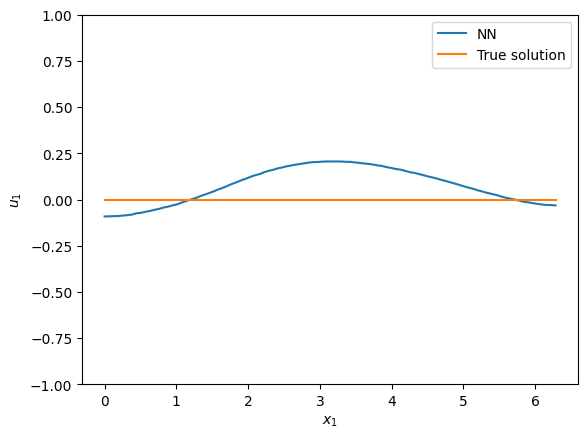

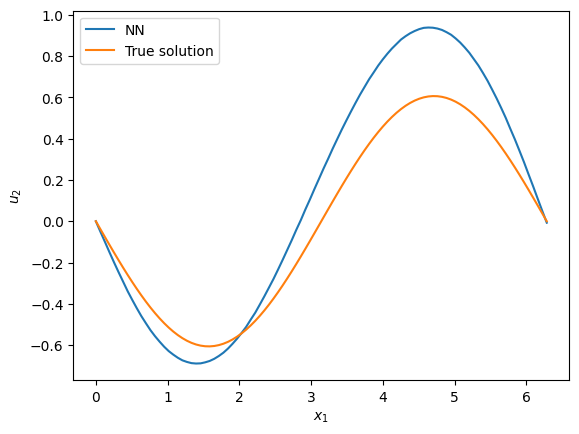

In [8]:
model.error_calculation(
    exact_u_fun=partial(exact_example_u_tensor, nu=nu, T=T),
    exact_p_fun=exact_example_p_tensor,
    nb_pts_spatial=2*126+1
)
model.compare_with_exact(exact_fun=partial(exact_example, nu=nu), exclude_terminal=True, ylim=(-1, 1))

### without boundary condition $[0, 1]^2$

In [ ]:
t_lo, x_lo, x_hi = 0., 0, 1

In [10]:
torch.manual_seed(0)
model = DGMNet(
    problem_name=problem_name,
    dgm_f_fun=f_example,
    phi_fun=phi_example,
    dgm_deriv_map=deriv_map,
    dgm_zeta_map=zeta_map,
    deriv_condition_deriv_map=deriv_condition_deriv_map,
    deriv_condition_zeta_map=deriv_condition_zeta_map,
    t_hi=T,
    x_lo=x_lo,
    x_hi=x_hi,
    device=device,
    verbose=True,
    epochs=20000,
    dgm_nb_states=10000,
)
model.train_and_eval()

Logs are saved in /home/oem/deep_branching_with_domain/notebooks/logs/20221201-230313-taylor_green_2d
Epoch 0 with loss 0.3408336937427521
Epoch 500 with loss 0.0010709649650380015
Epoch 1000 with loss 0.00039136101258918643
Epoch 1500 with loss 0.00021721118537243456
Epoch 2000 with loss 0.0001376164727844298
Epoch 2500 with loss 0.00010451307753100991
Epoch 3000 with loss 0.00022868302767165005
Epoch 3500 with loss 6.85762133798562e-05
Epoch 4000 with loss 5.449229502119124e-05
Epoch 4500 with loss 8.08190816314891e-05
Epoch 5000 with loss 4.529957004706375e-05
Epoch 5500 with loss 3.201944491593167e-05
Epoch 6000 with loss 6.293044134508818e-05
Epoch 6500 with loss 4.4290234654909e-05
Epoch 7000 with loss 9.785660950001329e-05
Epoch 7500 with loss 0.00012689412687905133
Epoch 8000 with loss 2.567010778875556e-05
Epoch 8500 with loss 1.450540639780229e-05
Epoch 9000 with loss 2.2107691620476544e-05
Epoch 9500 with loss 9.861584658210631e-06
Epoch 10000 with loss 1.0303971976100001e-0

The error as in Lejay is calculated as follows.
$\hat{e}_0(t_k)$
& 1.48E-01 & 1.33E-01 & 1.33E-01 & 1.35E-01 & 1.36E-01 & 1.38E-01 & 1.39E-01 & 1.41E-01 & 1.42E-01 & 1.44E-01 & --- \\
$\hat{e}_1(t_k)$
& 9.81E-02 & 8.38E-02 & 7.00E-02 & 5.66E-02 & 4.40E-02 & 3.23E-02 & 2.19E-02 & 1.31E-02 & 6.21E-03 & 1.69E-03 & --- \\
$\hat{e}(t_k)$
& 2.15E-01 & 2.02E-01 & 1.91E-01 & 1.79E-01 & 1.68E-01 & 1.58E-01 & 1.50E-01 & 1.45E-01 & 1.42E-01 & 1.44E-01 & --- \\
\hline

The relative L2 error of u (erru) is calculated as follows.
erru($t_k$)
& 9.71E-01 & 8.94E-01 & 8.20E-01 & 7.50E-01 & 6.84E-01 & 6.22E-01 & 5.63E-01 & 5.09E-01 & 4.59E-01 & 4.15E-01 & --- \\

The relative L2 error of gradient of u (errgu) is calculated as follows.
errgu($t_k$)
& 4.46E-01 & 3.98E-01 & 3.54E-01 & 3.16E-01 & 2.84E-01 & 2.60E-01 & 2.43E-01 & 2.35E-01 & 2.35E-01 & 2.43E-01 & --- \\

The absolute divergence of u (errdivu) is calculated as follows.
errdivu($t_k$)
& 8.18E-04 & 7.89E-04 & 7.78E-04 & 7.79E-04 & 7.87E-04 & 8.0

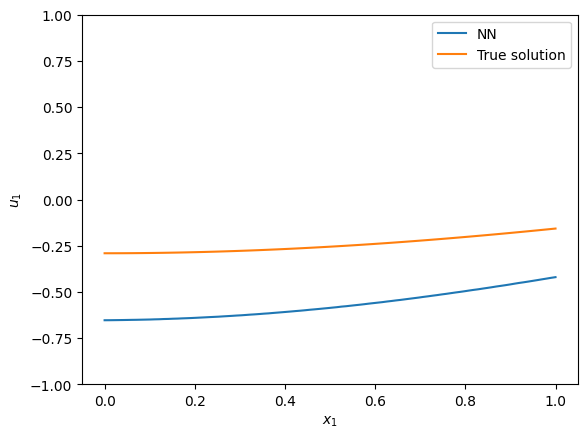

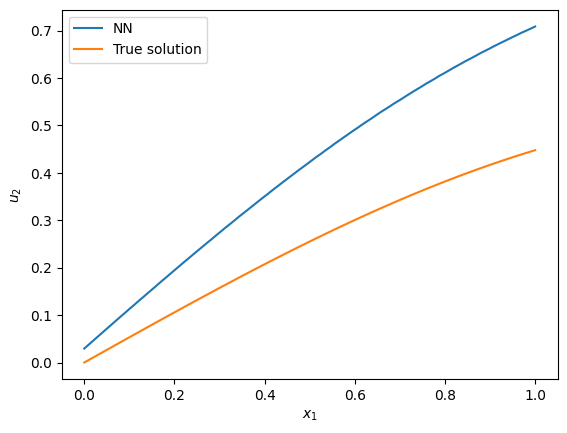

In [11]:
model.error_calculation(
    exact_u_fun=partial(exact_example_u_tensor, nu=nu, T=T),
    exact_p_fun=exact_example_p_tensor,
    nb_pts_spatial=2*126+1
)
model.compare_with_exact(exact_fun=partial(exact_example, nu=nu), exclude_terminal=True, ylim=(-1, 1))

### with boundary condition $[0, 1]^2$

In [12]:
torch.manual_seed(0)
model = DGMNet(
    problem_name=problem_name,
    dgm_f_fun=f_example,
    phi_fun=phi_example,
    dgm_deriv_map=deriv_map,
    dgm_zeta_map=zeta_map,
    deriv_condition_deriv_map=deriv_condition_deriv_map,
    deriv_condition_zeta_map=deriv_condition_zeta_map,
    t_hi=T,
    x_lo=x_lo,
    x_hi=x_hi,
    device=device,
    verbose=True,
    epochs=20000,
    dgm_nb_states=10000,
    boundary_fun=boundary_fun,
    overtrain_rate=.0,
)
model.train_and_eval()

Logs are saved in /home/oem/deep_branching_with_domain/notebooks/logs/20221201-234213-taylor_green_2d
Epoch 0 with loss 0.44750458002090454
Epoch 500 with loss 0.002782892668619752
Epoch 1000 with loss 0.0012584985233843327
Epoch 1500 with loss 0.00038679747376590967
Epoch 2000 with loss 0.00024317484349012375
Epoch 2500 with loss 0.0001924595853779465
Epoch 3000 with loss 0.0007300645229406655
Epoch 3500 with loss 9.556658915244043e-05
Epoch 4000 with loss 5.718684406019747e-05
Epoch 4500 with loss 0.0010299242567270994
Epoch 5000 with loss 0.00018624725635163486
Epoch 5500 with loss 5.280317418510094e-05
Epoch 6000 with loss 5.4308293329086155e-05
Epoch 6500 with loss 4.1967694414779544e-05
Epoch 7000 with loss 2.1275041945045814e-05
Epoch 7500 with loss 0.00014184831525199115
Epoch 8000 with loss 2.2481215637526475e-05
Epoch 8500 with loss 0.0005824065301567316
Epoch 9000 with loss 1.3813735677103978e-05
Epoch 9500 with loss 1.2857293768320233e-05
Epoch 10000 with loss 2.17332781176

The error as in Lejay is calculated as follows.
$\hat{e}_0(t_k)$
& 2.05E-03 & 1.85E-03 & 2.46E-03 & 3.31E-03 & 4.47E-03 & 6.01E-03 & 8.06E-03 & 1.07E-02 & 1.44E-02 & 1.95E-02 & --- \\
$\hat{e}_1(t_k)$
& 1.03E-04 & 7.93E-05 & 6.25E-05 & 5.07E-05 & 4.29E-05 & 3.81E-05 & 3.58E-05 & 3.55E-05 & 3.70E-05 & 4.01E-05 & --- \\
$\hat{e}(t_k)$
& 2.15E-03 & 1.86E-03 & 2.47E-03 & 3.32E-03 & 4.47E-03 & 6.01E-03 & 8.06E-03 & 1.07E-02 & 1.44E-02 & 1.95E-02 & --- \\
\hline

The relative L2 error of u (erru) is calculated as follows.
erru($t_k$)
& 6.77E-02 & 7.48E-02 & 8.56E-02 & 9.85E-02 & 1.13E-01 & 1.27E-01 & 1.43E-01 & 1.58E-01 & 1.73E-01 & 1.88E-01 & --- \\

The relative L2 error of gradient of u (errgu) is calculated as follows.
errgu($t_k$)
& 1.40E-01 & 1.25E-01 & 1.12E-01 & 1.02E-01 & 9.63E-02 & 9.42E-02 & 9.62E-02 & 1.02E-01 & 1.11E-01 & 1.21E-01 & --- \\

The absolute divergence of u (errdivu) is calculated as follows.
errdivu($t_k$)
& 2.83E-03 & 2.95E-03 & 3.05E-03 & 3.12E-03 & 3.17E-03 & 3.2

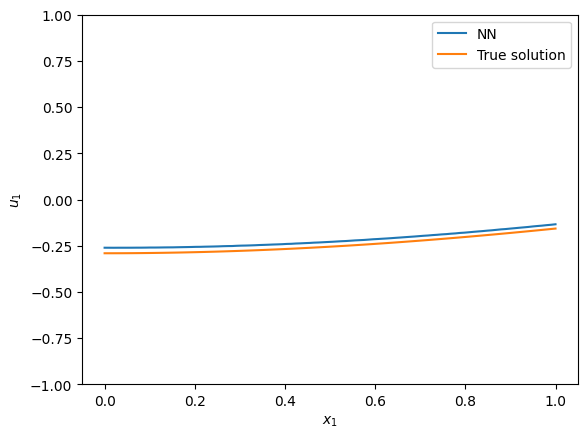

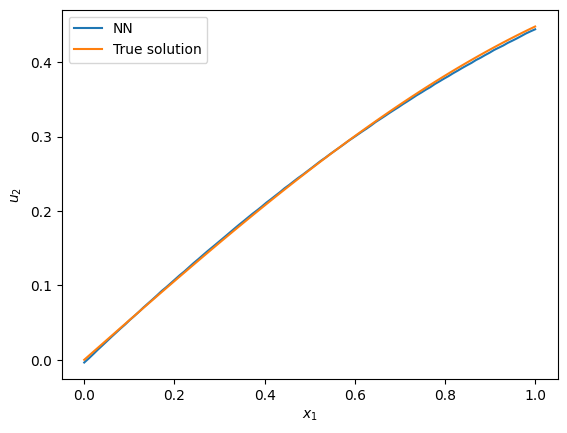

In [13]:
model.error_calculation(
    exact_u_fun=partial(exact_example_u_tensor, nu=nu, T=T),
    exact_p_fun=exact_example_p_tensor,
    nb_pts_spatial=2*126+1
)
model.compare_with_exact(exact_fun=partial(exact_example, nu=nu), exclude_terminal=True, ylim=(-1, 1))